In [1]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyro
import numpy as np
import pyro.distributions as dist

from pyciemss.ODE.askem_primitives import sample, infer_parameters, intervene, optimization
from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from typing import Dict, Optional

from pyciemss.utils import get_tspan

/Users/zuck016/.pyenv/versions/jz-scenario1-eval/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_ylim(0, 1.1)
    ax.set_ylabel('Proportion of Individuals')
    return ax

def plot_predictive(prediction, tspan, plot_var, plot_index=None, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):


    if plot_index is not None:
        low = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var][:, :, 0, plot_index], 0.95, dim=0).detach().numpy()
    else:
        low = torch.quantile(prediction[plot_var], 0.05, dim=0).detach().numpy()
        up = torch.quantile(prediction[plot_var], 0.95, dim=0).detach().numpy()        

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], low[indeces], up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    ax.set_xlabel('Time /days')

    return ax

def plot_trajectory(data, tspan, plot_var, plot_index=None, ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if plot_index is not None:
        result = data[plot_var][:, :, 0, plot_index].squeeze().detach().numpy()
    else:
        result = data[plot_var].squeeze().detach().numpy()


    ax.plot(tspan, result, color, alpha=alpha, lw=lw, marker=marker, label=label)
    ax.set_xlabel('Time /days')
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

# **Overview** 

## In this notebook we use pyciemss, an early prototype of the CIEMSS team's probabilistic programming software for simulation modeling, to answer a number of questions related to epidemiological analysis using a stratified SIR model. 

To emphasize our team's probabilistic reasoning capabilities, we have elaborated on the scenario questions to include uncertainty in model parameters.

To emphasize our team's causal reasoning capabilities, we have elaborated on the scenario questions to include more complicated interventions. Specifically, we explore interventions that can not simply be represented as a change in parameters, instead requiring manipulation of the simulation runtime.



## Model

The following model implements the stratified SIR scenario for all of the scenario questions. Note, that the model is defined over tensors of stratified $S$, $I$, and $R$ variables, where each element represents a different stratum. This means that the same model applies regardless of the number of stratum.

In [3]:
from pyro.nn import pyro_method

from pyciemss.ODE.base import ODE, Time, State, Solution, Observation
from pyciemss.utils import state_flux_constraint

class StratifiedSIR(ODE):
    def __init__(self,
                C_prior,
                Ro_prior,
                gamma_prior
                ):
        super().__init__()

        self.C_prior = C_prior
        self.Ro_prior = Ro_prior
        self.gamma_prior = gamma_prior

    @pyro_method
    def deriv(self, t: Time, state: State) -> State:
        '''
        This method defines the derivative of `state` as a function of `state` and `t`.
        '''
        
        S, I, R = state
        
        SI_flux = state_flux_constraint(S, pyro.deterministic("SI_flux %f" % (t), (torch.transpose(S, 0, 1) * I) * self.C * self.Ro).sum(axis=1))

        IR_flux = state_flux_constraint(I, pyro.deterministic("IR_flux %f" % (t), I * self.gamma))

        dSdt = -SI_flux
        dIdt = SI_flux - IR_flux
        dRdt = IR_flux

        return dSdt, dIdt, dRdt

    @pyro_method
    def param_prior(self) -> None:
        '''
        This method samples each parameter from its corresponding prior.
        '''

        self.C = pyro.sample("C", self.C_prior)
        self.Ro = pyro.sample("Ro", self.Ro_prior)
        self.gamma = pyro.sample("gamma", self.gamma_prior)

    @pyro_method
    def observation_model(self, solution: Solution, data: Optional[Dict[str, State]] = None) -> Solution:
        '''
        This method defines how observations probabilistically relate to the true state trajectory over time.
        This is also sometimes called a "noise model".
        '''
        names = ["S", "I", "R"]

        solution = tuple(torch.where(s > 0, s, 0) for s in solution)
        # Add no noise to the observation, as we're not conditioning on any data and don't need to use this for inference.
        return [pyro.deterministic(names[i], solution[i]) for i in range(len(names))]

# **Question 1.** 

**Subtask A** - Stratify by young, middle, and old age and simulate with many configurations.

First, we set up all of the initial conditions and priors that are persistent across a.i, a.ii, etc.

Note that as we are applying a probabilistic approach, we interpret every statement of the form "assume the parameters are x" to mean "assume the prior over parameters are centered at x, with some user-specified distribution". 

In [4]:
# INITIAL CONDITIONS

# Note: the SIR model is normalized such that S + I + R = 1. We process data accordingly.

N = 6000

# initial state is a tuple of (S, I, R) where S, I, and R are 1x3 tensors representing the population within each of 3 stratum.
# initial_state = (torch.ones(1, 3) * 1999., torch.ones(1, 3), torch.zeros(1, 3))

# The story of this notebook is more interesting when we assume only 1 young person is infected.
# Then, the cross-stratum terms in the contact matrix actually matter!

initial_state_a = (torch.tensor([[1999., 2000., 2000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_a = tuple(torch.as_tensor(s)/N for s in initial_state_a)

# Simulate for 25 days, with 100 simulation steps
tspan = get_tspan(1, 100, 100)

# simulation parameters
num_samples = 50

In [6]:
def LogNormalPrior(mean, variance):
    mu = torch.log(mean**2/torch.sqrt((mean**2 + variance)))
    scale = torch.sqrt(torch.log(1 + variance/mean**2))
    return dist.LogNormal(mu, scale)

In [7]:
# PRIOR SPECIFICATIONS

# The problem statement asserted that Ro=5. As mentioned previously, we interpret this to mean that the mean of our prior is equal to 5.
# Here, we use a LogNormal distribution to ensure that Ro is strictly greater than 0, but otherwise unbounded.
# https://en.wikipedia.org/wiki/Log-normal_distribution

Ro_mean   = torch.tensor(5.)
Ro_scale  = torch.tensor(0.001)

Ro_prior = LogNormalPrior(Ro_mean, Ro_scale)

# Prior taken from FunMAN team - TODO get clarity
# Ro_prior = dist.Uniform(1e-05,  0.0001337500000000001)

# The problem statement asserted that gamma = 1/14. Similar to Ro, we interpret this to mean that the mena of the prior is equal to 1/14.
# Again, we use a LogNormal distribution for the same reason as before.

# NOTE: set the variance of these priors to be very low. TODO: check back here to see if I still want to do this

gamma_mean  = torch.tensor(1/14)
gamma_scale = torch.tensor(0.0001)

gamma_prior = LogNormalPrior(gamma_mean, gamma_scale)

# Prior taken from FunMAN team - TODO get clarity
# gamma_prior = dist.Uniform(0.023716517857142856,  0.023809523809523808)

To represent our uncertainty over contact matrices, we use a Dirichlet distribution (https://en.wikipedia.org/wiki/Dirichlet_distribution), which enforces the constraint that all elements in each row of the sampled matrix must sum to 1. For each subpart below, as before, the dirichlet parameters are chosen to match the mean value of the problem statement. However, as we'll see, we have signficant degrees of freedom in how much uncertainty we place on the contact rate matrix.

## Part i
"Simulate this model for the case where the 3x3 contact matrix is uniform (all values in matrix are 0.33)"





In [8]:
C_mean = torch.tensor([[1., 1., 1.], 
                        [1., 1., 1.], 
                        [1., 1., 1.]])/3


# Then, let's see how samples from the dirichlet prior look in two extreme settings. Setting `scale` to be very large means that we are very confident about
# what the contact rate should be.

C_prior_confident = LogNormalPrior(C_mean, 1e-6)
C_prior_uncertain = LogNormalPrior(C_mean, 1)

for i in range(3):
    print(f"Confident Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_confident())
    print("\n")

for i in range(3):
    print(f"Uncertain Prior over Contact Matrix - Sample {i+1}")
    print(C_prior_uncertain())
    print("\n")

Confident Prior over Contact Matrix - Sample 1
tensor([[0.3321, 0.3324, 0.3330],
        [0.3325, 0.3347, 0.3344],
        [0.3338, 0.3335, 0.3324]])


Confident Prior over Contact Matrix - Sample 2
tensor([[0.3342, 0.3337, 0.3330],
        [0.3316, 0.3312, 0.3323],
        [0.3330, 0.3320, 0.3341]])


Confident Prior over Contact Matrix - Sample 3
tensor([[0.3332, 0.3331, 0.3323],
        [0.3339, 0.3329, 0.3351],
        [0.3347, 0.3346, 0.3341]])


Uncertain Prior over Contact Matrix - Sample 1
tensor([[0.1192, 0.0887, 0.3118],
        [0.0355, 0.1679, 0.0698],
        [0.2152, 0.1109, 0.0153]])


Uncertain Prior over Contact Matrix - Sample 2
tensor([[0.2131, 0.2645, 0.1337],
        [0.0167, 0.1844, 0.0152],
        [0.0940, 0.0359, 0.3298]])


Uncertain Prior over Contact Matrix - Sample 3
tensor([[0.2627, 0.9444, 2.0704],
        [1.8353, 0.0513, 0.0141],
        [0.0203, 0.1589, 0.2763]])




Using our CIEMSS primitives, let's explore how these changes to model parameters influence the resulting distribution over simulation outputs.
To do this, we simply call the `sample` method, which runs the simulator repeatedly with model parameters sampled from the prior.

In [9]:
def run_scenario1(C_mean, initial_state, title):

    predictions = {}
    variances = [0.0001, 0.001, 0.01, 0.1, 1]

    # Simulate from the stratified SIR model.
    for variance in variances:
        C_prior = LogNormalPrior(C_mean, variance)
        ode_model = StratifiedSIR(C_prior, Ro_prior, gamma_prior)
        predictions[variance] = sample(ode_model, num_samples, initial_state, tspan)

    # Generate a bunch of plots.

    fig, ax = plt.subplots(1, len(variances), sharey=True, figsize=(len(variances) * 3, 3))
    fig.suptitle(title, fontsize=16)
    plt.subplots_adjust(top=0.8)

    ax[0] = setup_ax(ax[0])

    for i, variance in enumerate(predictions):
        prediction = predictions[variance]

        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=0, ax=ax[i], label="I_young", hatch='.', edgecolor="blue", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=1, ax=ax[i], label="I_middle", hatch='/', edgecolor="green", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i] = plot_predictive(prediction, tspan, plot_var="I", plot_index=2, ax=ax[i], label="I_old", hatch='\\', edgecolor="red", facecolor="none", linewidth=2.5, alpha=0.5)
        ax[i].set_title(f"Prior Variance = {variance}")

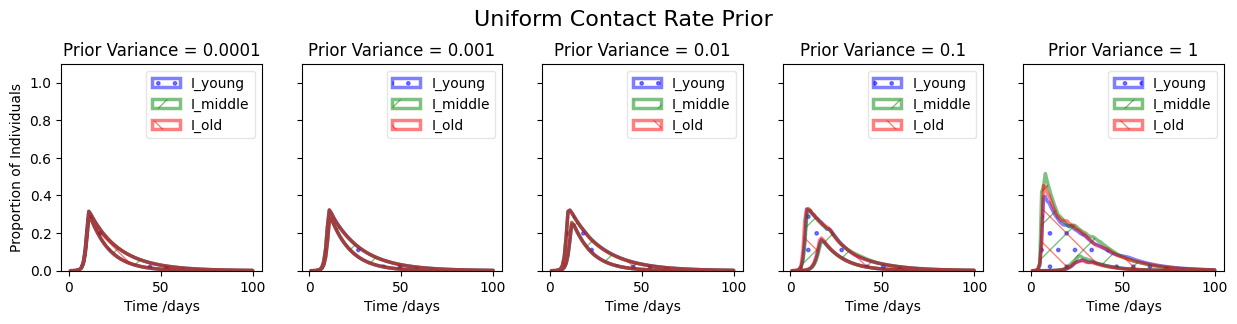

In [10]:
C_mean_uniform = torch.tensor([[0.33, 0.33, 0.33], 
                                [0.33, 0.33, 0.33], 
                                [0.33, 0.33, 0.33]])

run_scenario1(C_mean_uniform, initial_state_a, "Uniform Contact Rate Prior")

## Part ii
"Simulate this model for the case where there is significant in-group contact preference – you may choose the numbers in the matrix to represent this in-group preference."





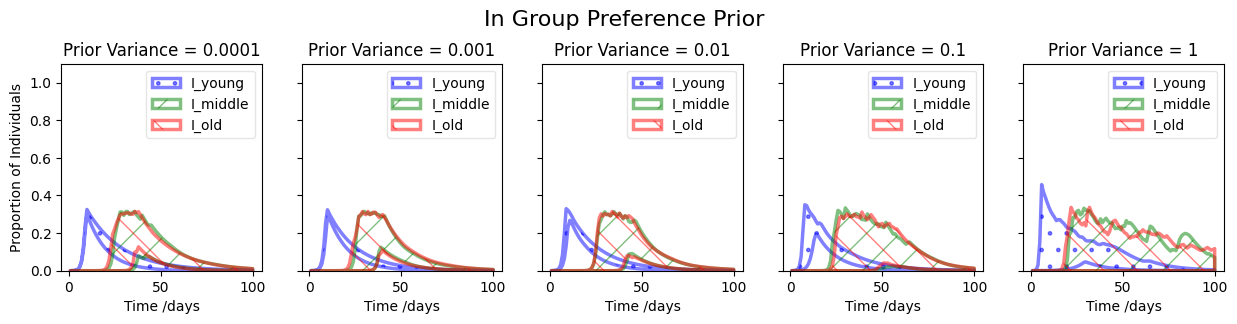

In [12]:
C_mean_in_group = torch.tensor([[1., 1e-6, 1e-6], 
                                [1e-6, 1., 1e-6], 
                                [1e-6, 1e-6, 1.]])

run_scenario1(C_mean_in_group, initial_state_a, "In Group Preference Prior")

Using our CIEMSS primitives, let's again explore how these changes to model parameters influence the resulting distribution over simulation outputs.

## Part iii
"Simulate this model for the case where there is no contact between age groups. You may choose the numbers in the matrix, but ensure it meets the requirement of no contact between age groups."

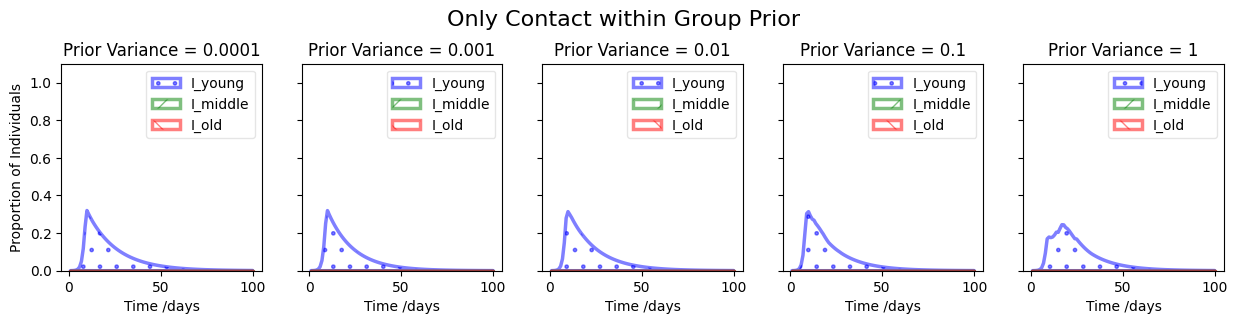

In [13]:
C_mean_in_group_extreme = torch.tensor([[1., 0., 0.], 
                                        [0., 1., 0.], 
                                        [0., 0., 1.]])

run_scenario1(C_mean_in_group_extreme, initial_state_a, "Only Contact within Group Prior")

## Part iv
"Simulate social distancing by scaling down the uniform contact matrix by a factor (e.g. multiply by 0.5)"

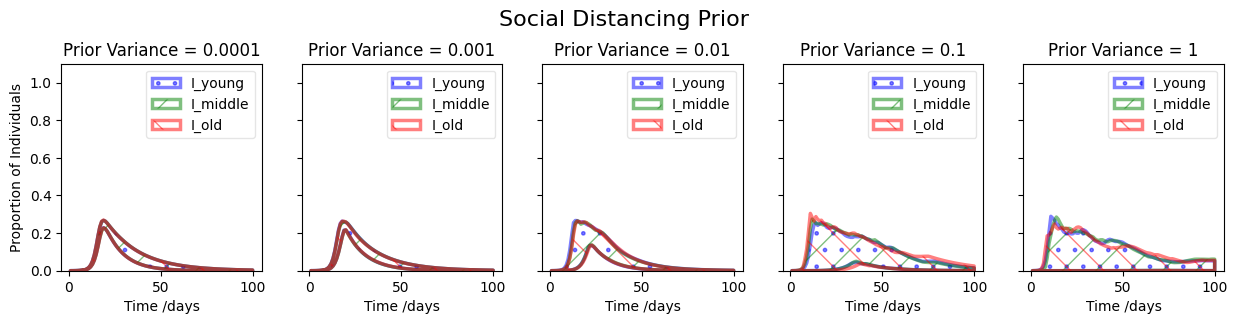

In [14]:
run_scenario1(C_mean_uniform * 0.5, initial_state_a, "Social Distancing Prior")

## Part v
"Repeat 1.a.iv for the scenario where the young population has poor compliance with social distancing policies, but the old population is very compliant."

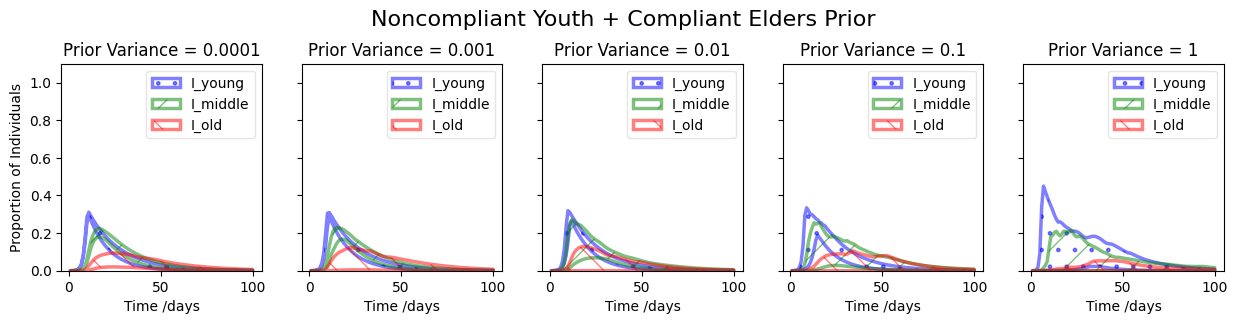

In [15]:
C_mean_noncompliant = torch.tensor([[0.9, 0.1, 0.01], 
                                    [0.1, 0.1, 0.01], 
                                    [0.01, 0.01, 0.01]])

run_scenario1(C_mean_noncompliant, initial_state_a, "Noncompliant Youth + Compliant Elders Prior")

**Subtask B** - "Repeat 1.a for a younger-skewing population: N_young = 3k, N_middle = 2k, N_old = 1k"

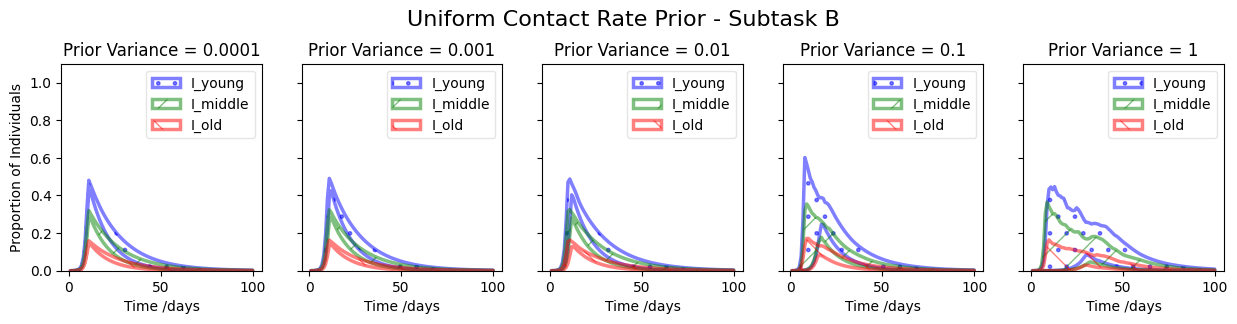

In [16]:
initial_state_b = (torch.tensor([[2999., 2000., 1000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_b = tuple(torch.as_tensor(s)/N for s in initial_state_b)

run_scenario1(C_mean_uniform, initial_state_b, "Uniform Contact Rate Prior - Subtask B")

**Subtask C** - "Repeat 1.a for an older-skewing population: N_young = 1k, N_middle = 2k, N_old = 3k"

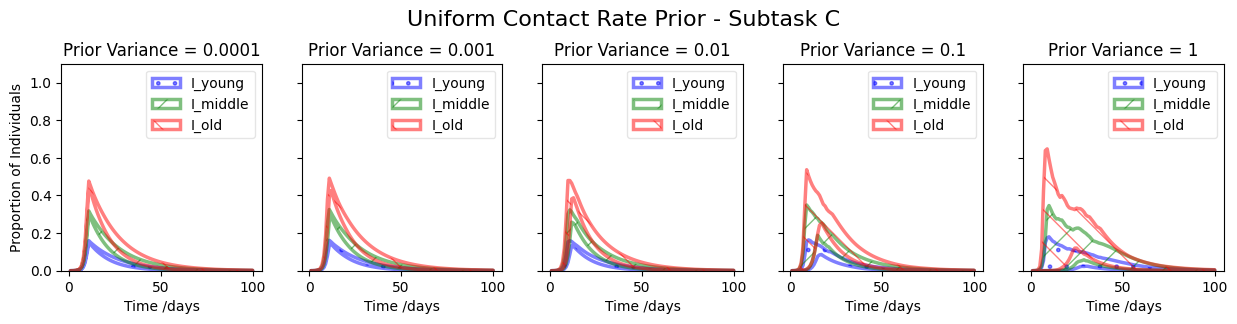

In [18]:
initial_state_c = (torch.tensor([[999., 2000., 3000.]]), torch.tensor([[1., 0., 0.]]), torch.zeros(1, 3))
initial_state_c = tuple(torch.as_tensor(s)/N for s in initial_state_c)

run_scenario1(C_mean_uniform, initial_state_c, "Uniform Contact Rate Prior - Subtask C")

**Subtask D** - "Compare simulation outputs from 1a-c, and describe any takeaways/conclusions."

In general, adding variance to the contact matrix provides information about which features of the simulation are robust to uncertainty and which features are sensitive to the specific values of the contact matrix. One feature that displays this property is the timing of the peak of infection for worst case scenarios, where the peak of infection was high, and scenarios where the peak of infection never exceeds a threshold.  No matter which initial contact matrix we were given, the timing of the peak of infection for worst case scenarios was robust to variance in the contact matrix. However, for average and best-case scenarios, the timing of the peak of infection  was much more sensitive to variance in the contact matrix.  This has implications for controllability: interventions that directly target preventing worst-case scenarios are more likely to be effective than interventions that hope to modify the peak of infection for best or average case scenarios.



